# Experimenting on MNIST

### About MNIST Dataset

 The **MNIST** database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems
 
 The **MNIST** database contains 60,000 training images and 10,000 testing images.
 Photo size: **28x28 p**.

### The Purpose of notebook

I will design and try two neural networks to get ~100% accuracy
- MLP (Multilayer perceptron)

- CNN (Convolutional neural network)

**Update:**
- I made this notebook 7 months ago, and it is one of my first data science projects. During this time I learned a lot of interesting things and put these things in here.

### Importing libs

In [1]:
import numpy as np
import pandas as pd

np.random.seed(0) 
import random

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##  Reading data

In [5]:
train = pd.read_csv("./digit-recognizer/train.csv")
test = pd.read_csv("./digit-recognizer/test.csv")


X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']

X_test = test

print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


## Exploratory Data Analysis

In [6]:
X_train_plot = X_train.values.reshape(-1, 28, 28)

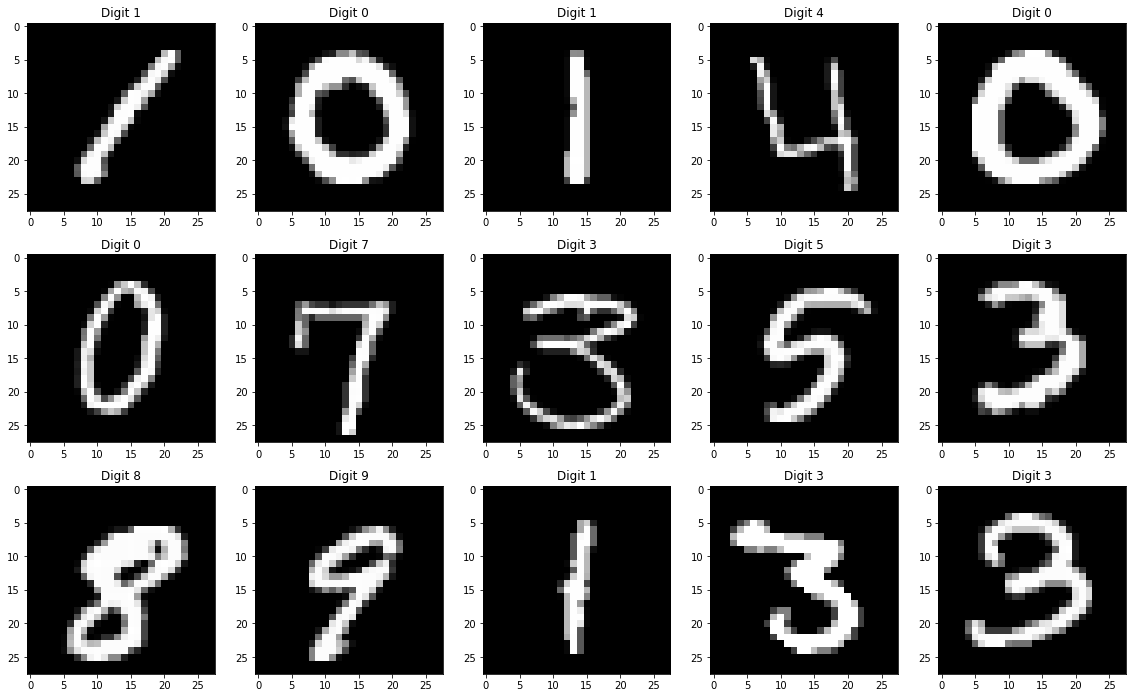

In [7]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))
        
    plt.tight_layout()
    
Show_example_digits()

In [8]:
# Function return digit in grayscale
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'
    
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

8


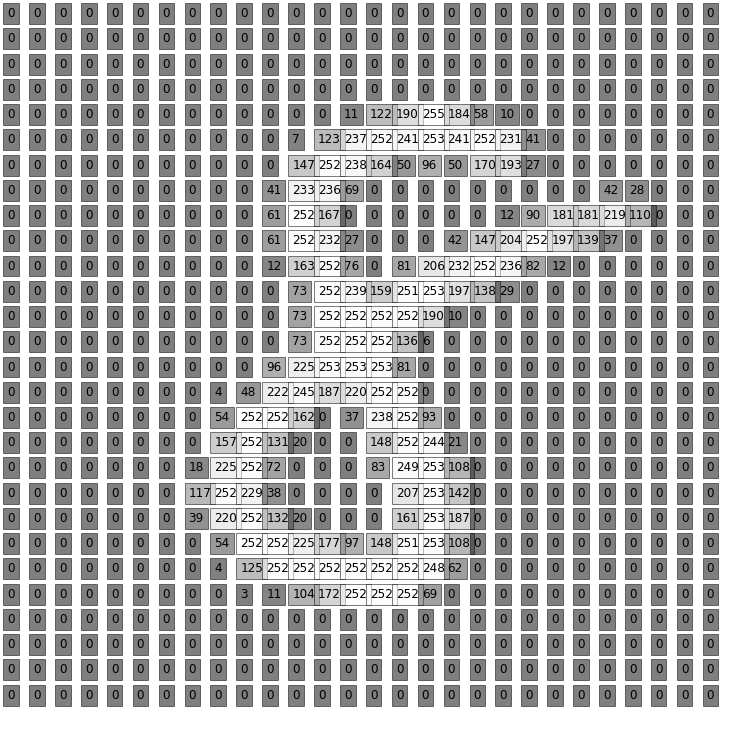

In [9]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

#### Chart of the number of digits in the data

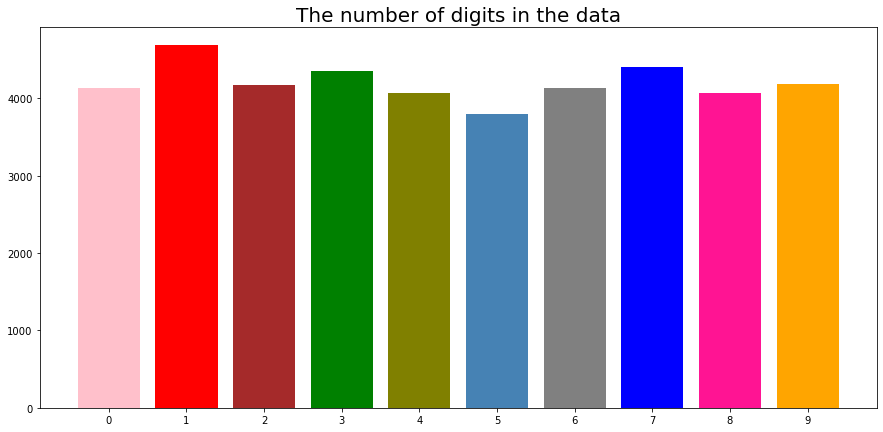

In [10]:
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

## Data Preparing

In [11]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1] 

input_shape = (img_rows, img_cols)

In [12]:
# Data Normalization [0, 1]
X_train /= 255
X_test /= 255

# one-hot encoding for target column
y_train = to_categorical(y_train)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


#### Split data

added stratified folds

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

## MLP ([Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))

### Structure

Firstly, let's think how the network should look like. It will have three layers:

1 Input Layer

2 Hidden Layer

3 Output Layer


Input layer has 28 * 28 pixels reshape to vector

Hidden layer has a lot of neurons

Output layer has 10 neurons 

Design network with using keras 

The metrics we use are f1_score

In [14]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Function to drawing learning curve history learning neural network



In [15]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

# Adding Callbacks
- EarlyStopping (Stop training when a monitored metric has stopped improving)
- ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)
- ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

In [16]:
def callbacks(name): 
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint(f'{name}.hdf5', save_best_only=True) # saving the best model
    ]

#### Simple MLP with one hidden layer

In [17]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [18]:
model = get_mlp()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Our network has 407,050 params (weights)

#### You can use **GPU** to accelerate training

In [20]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 10, verbose = 2, callbacks = callbacks('simple_mlp'),
          validation_data=(X_val, y_val));

Epoch 1/10
37/37 - 1s - loss: 0.1252 - f1: 0.9666 - val_loss: 0.1382 - val_f1: 0.9599
Epoch 2/10
37/37 - 0s - loss: 0.1081 - f1: 0.9712 - val_loss: 0.1266 - val_f1: 0.9607
Epoch 3/10
37/37 - 1s - loss: 0.0934 - f1: 0.9753 - val_loss: 0.1190 - val_f1: 0.9670
Epoch 4/10
37/37 - 0s - loss: 0.0832 - f1: 0.9784 - val_loss: 0.1094 - val_f1: 0.9656
Epoch 5/10
37/37 - 0s - loss: 0.0726 - f1: 0.9809 - val_loss: 0.1046 - val_f1: 0.9665
Epoch 6/10
37/37 - 0s - loss: 0.0642 - f1: 0.9833 - val_loss: 0.1008 - val_f1: 0.9687
Epoch 7/10
37/37 - 0s - loss: 0.0571 - f1: 0.9855 - val_loss: 0.0931 - val_f1: 0.9723
Epoch 8/10
37/37 - 1s - loss: 0.0515 - f1: 0.9875 - val_loss: 0.0916 - val_f1: 0.9722
Epoch 9/10
37/37 - 0s - loss: 0.0459 - f1: 0.9887 - val_loss: 0.0897 - val_f1: 0.9726
Epoch 10/10
37/37 - 0s - loss: 0.0405 - f1: 0.9905 - val_loss: 0.0873 - val_f1: 0.9746


In [21]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.727287501096725%
Test score: 97.12892174720764%
MLP Error: 2.87%


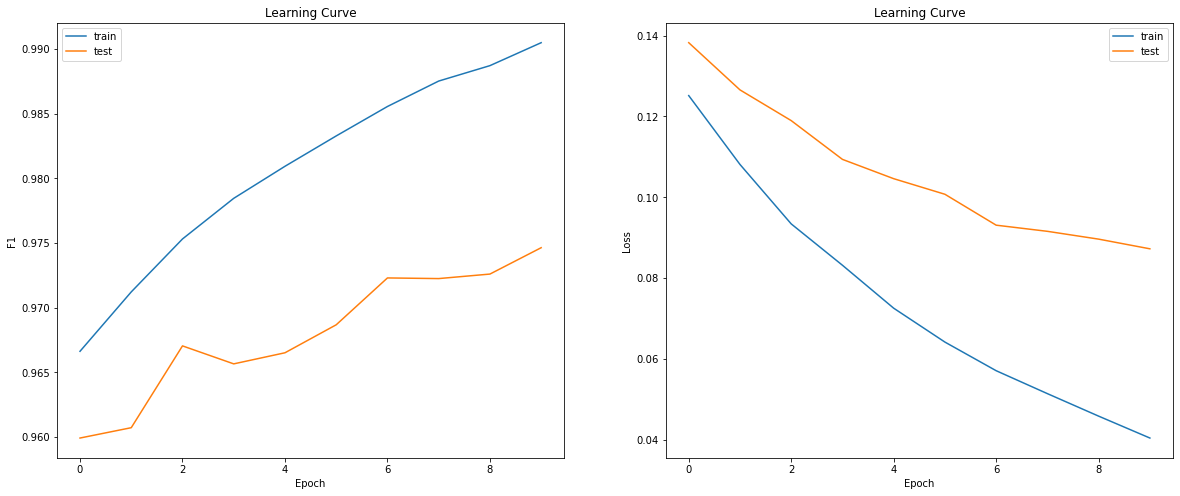

In [22]:
draw_learning_curve(learning_history)

Cool! I get ~98% accuracy with easy model MLP and i didn't work too much.

According to Pareto principle 80/20 in this case 20% work generate ~80%~ 98% accuracy :)

#### Adding new layer and Dropout to avoid overfitting

In [23]:
def get_mlpv2():
    
    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [24]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
________________________________________________

Run new model 

In [25]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 10, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));

Epoch 1/10
37/37 - 1s - loss: 0.7619 - f1: 0.6880 - val_loss: 0.2775 - val_f1: 0.9178
Epoch 2/10
37/37 - 1s - loss: 0.2509 - f1: 0.9252 - val_loss: 0.1704 - val_f1: 0.9436
Epoch 3/10
37/37 - 1s - loss: 0.1752 - f1: 0.9473 - val_loss: 0.1346 - val_f1: 0.9569
Epoch 4/10
37/37 - 1s - loss: 0.1389 - f1: 0.9577 - val_loss: 0.1101 - val_f1: 0.9622
Epoch 5/10
37/37 - 1s - loss: 0.1110 - f1: 0.9665 - val_loss: 0.0979 - val_f1: 0.9717
Epoch 6/10
37/37 - 1s - loss: 0.0908 - f1: 0.9718 - val_loss: 0.0890 - val_f1: 0.9729
Epoch 7/10
37/37 - 1s - loss: 0.0777 - f1: 0.9764 - val_loss: 0.0801 - val_f1: 0.9766
Epoch 8/10
37/37 - 1s - loss: 0.0658 - f1: 0.9804 - val_loss: 0.0768 - val_f1: 0.9762
Epoch 9/10
37/37 - 1s - loss: 0.0548 - f1: 0.9827 - val_loss: 0.0729 - val_f1: 0.9783
Epoch 10/10
37/37 - 1s - loss: 0.0494 - f1: 0.9841 - val_loss: 0.0729 - val_f1: 0.9808


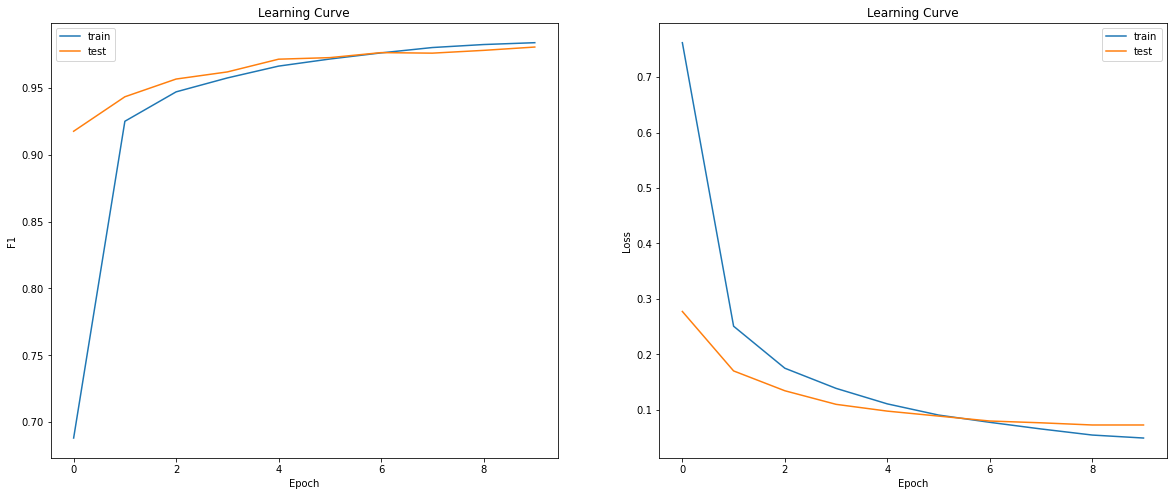

In [26]:
draw_learning_curve(learning_history)

In [27]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 7.292947173118591%
Test score: 97.67313599586487%
MLP Error: 2.33%


#### I slightly improved the model, so we keep working.

## CNN ([Convolutional_neural_network](https://en.wikipedia.org/wiki/Convolutional_neural_network))

CNN consists with:
- convolution layer
- in the past MLP

It will use 3 convolutional layers: (Conv2D, Conv2D, pool)

#### We need to reshape data.

In [28]:
X_train.shape

(37800, 784)

In [29]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [30]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [31]:
model = get_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)         

In [33]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 10,
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

Epoch 1/10
296/296 [==============================] - 35s 118ms/step - loss: 0.3091 - f1: 0.8988 - val_loss: 0.0646 - val_f1: 0.9791
Epoch 2/10
296/296 [==============================] - 33s 112ms/step - loss: 0.0954 - f1: 0.9726 - val_loss: 0.0436 - val_f1: 0.9868
Epoch 3/10
296/296 [==============================] - 33s 111ms/step - loss: 0.0675 - f1: 0.9812 - val_loss: 0.0467 - val_f1: 0.9857
Epoch 4/10
296/296 [==============================] - 37s 123ms/step - loss: 0.0552 - f1: 0.9840 - val_loss: 0.0379 - val_f1: 0.9886
Epoch 5/10
296/296 [==============================] - 36s 122ms/step - loss: 0.0482 - f1: 0.9864 - val_loss: 0.0341 - val_f1: 0.9892
Epoch 6/10
296/296 [==============================] - 36s 120ms/step - loss: 0.0412 - f1: 0.9889 - val_loss: 0.0402 - val_f1: 0.9894
Epoch 7/10
296/296 [==============================] - 36s 121ms/step - loss: 0.0368 - f1: 0.9894 - val_loss: 0.0312 - val_f1: 0.9919
Epoch 8/10
296/296 [==============================] - 37s 126ms/step 

In [34]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.030197540298104286
Test score: 0.9920446276664734
CNN Error: 0.80%


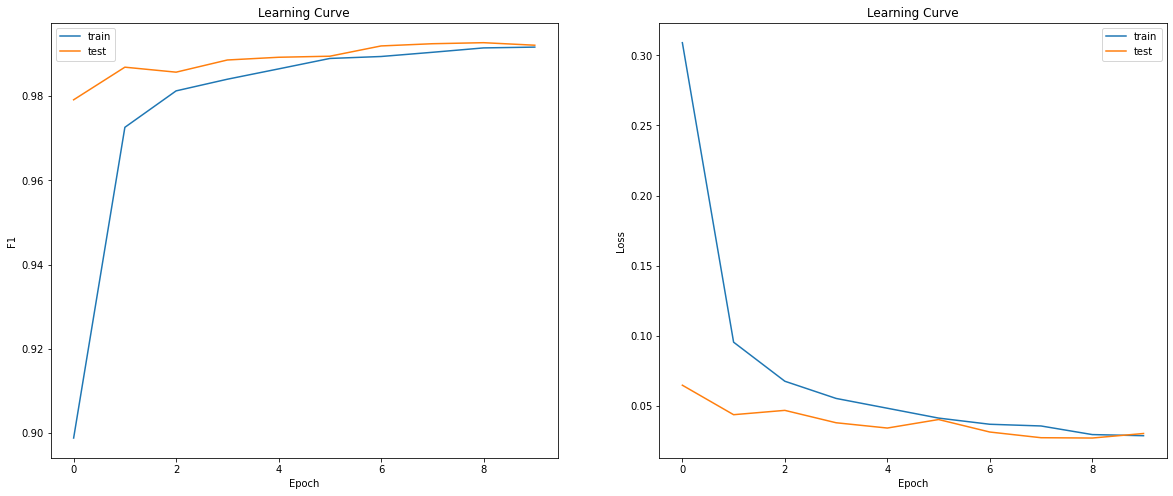

In [35]:
draw_learning_curve(learning_history)

### Let's see in which cases the model is invalid.

#### Let's assign the values provided by the model

In [36]:
y_pred = model.predict(X_val)

#### I made function to visual output

In [37]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = np.ceil(np.sqrt(len(idx_nums)))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]
        
        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10) 
        plt.bar(range(10), y_pred[ph])
        
        cnt += 1

#### The number of errors for the each digit

D:\anaconda3\envs\{tunglam}\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


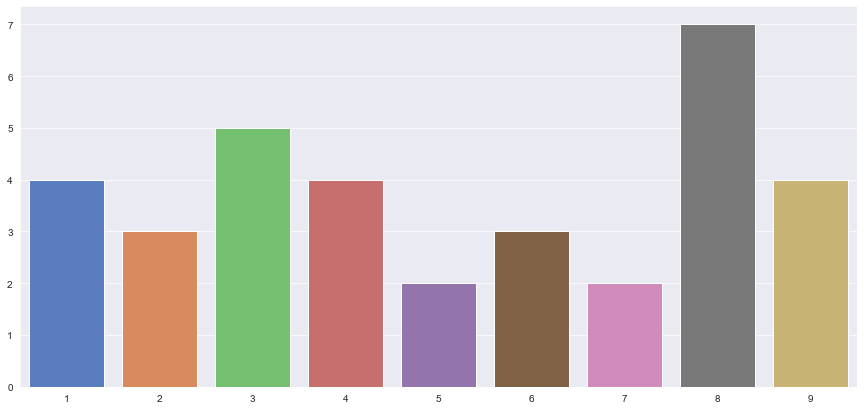

In [38]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    cnt_error.append( (np.argmax(a)) )

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
bar_plot = sns.barplot(cnt_error[0], cnt_error[1], palette="muted")
plt.show()

#### Let's see these photos (2, 9)

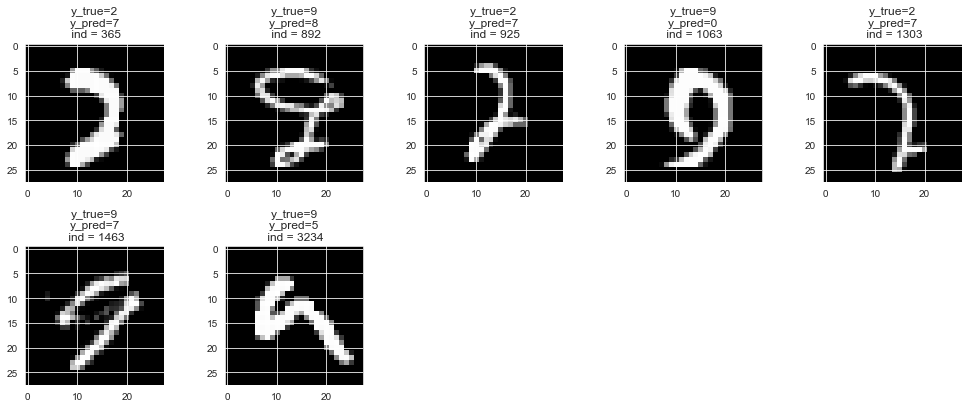

In [39]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 2 or np.argmax(a) == 9):    
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1

## Data Augmentation

#### I will try to improve the result by expanding the data. You have to be careful when rotating your photos not to misclassify numbers such as 9 and 6.

#### Data augmentation:

Randomly shift images horizontally by 10% of the width

Randomly shift images vertically by 10% of the height

Randomly rotate images by 10 degrees

Randomly Zoom by 10% some images


In [41]:
train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
        

train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

#### Building new model and using batch normalization

In [42]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
          
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [43]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)       

In [44]:
learning_history = model.fit_generator(train_gen, epochs = 10, 
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('best_cnn'),
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
590/590 [==============================] - 72s 122ms/step - loss: 0.6662 - f1: 0.7747 - val_loss: 0.2308 - val_f1: 0.9278
Epoch 2/10
590/590 [==============================] - 71s 121ms/step - loss: 0.1667 - f1: 0.9528 - val_loss: 0.0484 - val_f1: 0.9843
Epoch 3/10
590/590 [==============================] - 76s 129ms/step - loss: 0.1206 - f1: 0.9664 - val_loss: 0.0431 - val_f1: 0.9864
Epoch 4/10
590/590 [==============================] - 72s 123ms/step - loss: 0.0941 - f1: 0.9731 - val_loss: 0.0338 - val_f1: 0.9895
Epoch 5/10
590/590 [==============================] - 74s 126ms/step - loss: 0.0910 - f1: 0.9748 - val_loss: 0.0438 - val_f1: 0.9892
Epoch 6/10
590/590 [==============================] - 71s 121ms/step - loss: 0.0836 - f1: 0.9766 - val_loss: 0.0358 - val_f1: 0.9894
Epoch 7/10
590/590 [==============================] - 72s 121ms/step - loss: 0.0705 - f1: 0.9810 - val_loss: 0.0257 - val_f1: 

#### Loading the best model

In [46]:
model = load_model('./best_cnn.hdf5', custom_objects={"f1": f1})

In [47]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.025548305362462997
Test score: 0.9924129247665405
CNN Error: 0.76%


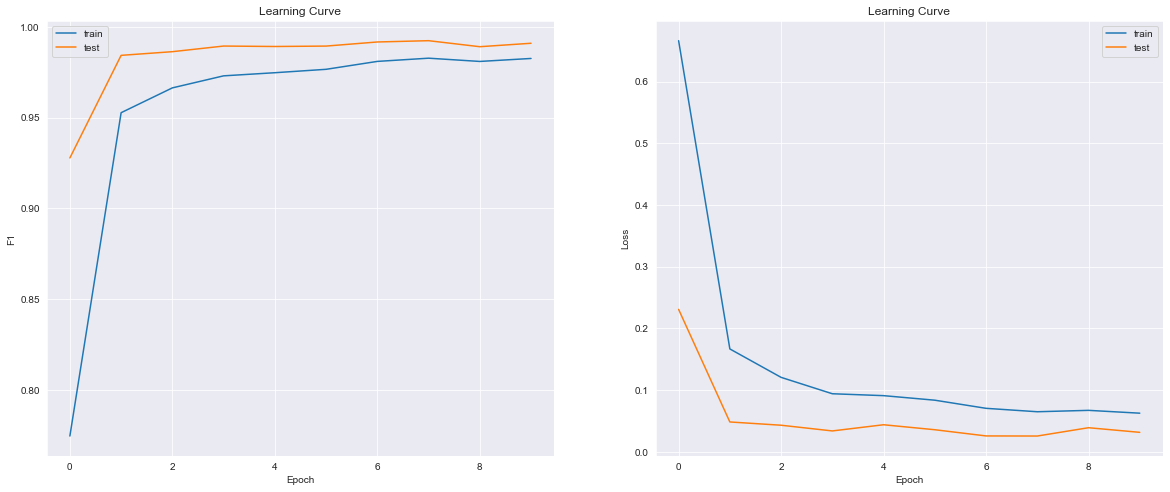

In [48]:
draw_learning_curve(learning_history)

#### We achieved a great result of 99.2% accuracy

# Generate output

In [43]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("submission.csv", index=False)

<font size="3">
    <div style="text-align: right"> <b> Author </b> </div>
</font>
<div style="text-align: right"> Jędrzej </div>
<div style="text-align: right"> Dudzicz </div>